### Emergency Detection

In [2]:
import pandas as pd
from detection import emergency_detection_workflow, prepare_data_for_detection, detect_emergency
from base.minio_utils import load_model_from_minio
from base.influx_utils import fetch_all_sensor_data
from base.homecare_hub_utils import send_info, send_todo

In [3]:
sensor_data = fetch_all_sensor_data(
    start_hours=24,
    interval_hours=24
)
prepared_df = prepare_data_for_detection(sensor_data)
prepared_df.tail(5)

2025-01-03 14:46:41 [INFO] detection - Starting data preparation for detection.
2025-01-03 14:46:41 [INFO] detection - Original data shape: (1060, 5)
2025-01-03 14:46:41 [INFO] detection - Handled 'sensor' as a list.
2025-01-03 14:46:41 [INFO] detection - Timestamps converted to datetime.
2025-01-03 14:46:41 [INFO] detection - Data sorted by timestamp.
2025-01-03 14:46:41 [INFO] detection - Sensor names encoded successfully.
2025-01-03 14:46:41 [INFO] detection - Mapped sensors to rooms.
2025-01-03 14:46:41 [INFO] detection - Identified room-change points and assigned group IDs.
2025-01-03 14:46:41 [INFO] detection - Calculated start and end times for each group.
2025-01-03 14:46:41 [INFO] detection - Computed durations for each group.
2025-01-03 14:46:41 [INFO] detection - Data preparation for detection completed.


,group_id,room,start_time,end_time,duration,duration_seconds
83,84,kitchen,2025-01-03 11:20:04.632,2025-01-03 11:31:46.201,0 days 00:11:41.569000,701.569
84,85,bathroom,2025-01-03 11:33:54.773,2025-01-03 11:33:54.773,0 days 00:00:00,0.000
85,86,kitchen,2025-01-03 11:35:58.009,2025-01-03 12:18:42.269,0 days 00:42:44.260000,2564.260
86,87,bathroom,2025-01-03 12:21:18.244,2025-01-03 12:21:32.604,0 days 00:00:14.360000,14.360
87,88,kitchen,2025-01-03 12:27:02.348,2025-01-03 13:44:26.684,0 days 01:17:24.336000,4644.336


In [124]:
room_stats = load_model_from_minio("occupancy")
room_stats

2025-01-03 13:32:44 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 13:32:44 [INFO] base.minio_utils - [OCCUPANCY MODEL] Latest object is 'model_occupancy_20250103021508.json'.
2025-01-03 13:32:44 [INFO] base.minio_utils - [OCCUPANCY MODEL] 'model_occupancy_20250103021508.json' downloaded.
2025-01-03 13:32:44 [INFO] base.minio_utils - [OCCUPANCY MODEL] Model deserialized successfully.


,room,mean,std
0,bathroom,12747.610875,111090.871078
1,kitchen,387.230530,981.634389
2,livingroom,247.514075,1091.449841


In [125]:
_, message = emergency_detection_workflow()
print(message)

2025-01-03 13:32:53 [INFO] detection - Initiating emergency detection workflow.
2025-01-03 13:32:53 [INFO] detection - Fetched 1046 sensor data records.
2025-01-03 13:32:53 [INFO] detection - Retrieving patient location and duration.
2025-01-03 13:32:53 [INFO] detection - Starting data preparation for detection.
2025-01-03 13:32:53 [INFO] detection - Original data shape: (1046, 5)
2025-01-03 13:32:53 [INFO] detection - Handled 'sensor' as a list.
2025-01-03 13:32:53 [INFO] detection - Timestamps converted to datetime.
2025-01-03 13:32:53 [INFO] detection - Data sorted by timestamp.
2025-01-03 13:32:53 [INFO] detection - Sensor names encoded successfully.
2025-01-03 13:32:53 [INFO] detection - Mapped sensors to rooms.
2025-01-03 13:32:53 [INFO] detection - Identified room-change points and assigned group IDs.
2025-01-03 13:32:53 [INFO] detection - Calculated start and end times for each group.
2025-01-03 13:32:53 [INFO] detection - Computed durations for each group.
2025-01-03 13:32:53 

🚨 Emergency Alert 🚨
Room: kitchen
Patient has spent 0:55:58 here.
Expected duration (mean): 0:06:27
Standard deviation (std): 0:16:22
Threshold used: 3
Allowed duration range: 0:00:00 - 0:55:32
Duration is outside the allowed range!


In [ ]:
room = "livingroom"
duration = 240  # seconds
stats = pd.Series({"mean": 120, "std": 30})

_, result = detect_emergency(room, duration, stats)
print(result)

2025-01-02 15:23:06 [INFO] detection - Room 'livingroom' stats - Mean: 120.00 seconds, Std: 30.00 seconds.
2025-01-02 15:23:06 [INFO] detection - Duration bounds for emergency detection: (30.00, 210.00) seconds.
2025-01-02 15:23:06 [WARNING] detection - 🚨 Emergency Alert 🚨
Room: livingroom
Patient has spent 0:04:00 here.
Expected duration (mean): 0:02:00
Standard deviation (std): 0:00:30
Threshold used: 3
Allowed duration range: 0:00:30 - 0:03:30
Duration is outside the allowed range!


🚨 Emergency Alert 🚨
Room: livingroom
Patient has spent 0:04:00 here.
Expected duration (mean): 0:02:00
Standard deviation (std): 0:00:30
Threshold used: 3
Allowed duration range: 0:00:30 - 0:03:30
Duration is outside the allowed range!


### Motion Analysis

In [1]:
from motion_analysis import (
    visualize_transitions_heatmap, 
    plot_bidirectional_transaction_graph, 
    summary_of_sleep_time_and_time_outside,
    count_daily_visits,
    detect_wake_up_times,
    detect_went_to_sleep_times,
    create_separate_heat_maps)
from base.minio_utils import load_model_from_minio
import pandas as pd
from base.homecare_hub_utils import send_info
from motion_analysis import analyse_motion_patterns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [11]:
old_model = load_model_from_minio("motion", 2)
new_model = load_model_from_minio("motion", 1)

2025-01-03 14:38:31 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 14:38:31 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-03 14:38:31 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.


In [12]:
old_model.head()

,from,to,leave_time,enter_time
0,livingroomdoor,kitchen,2024-11-29 15:51:17.000,2024-11-29 16:03:53.625
1,kitchen,livingroomdoor,2024-11-29 16:06:44.833,2024-11-29 16:06:54.000
2,livingroomdoor,kitchen,2024-11-29 16:06:54.000,2024-11-29 16:07:01.214
3,kitchen,livingroomdoor,2024-11-29 16:11:49.475,2024-11-29 16:11:52.000
4,livingroomdoor,kitchen,2024-11-29 16:11:52.000,2024-11-29 16:11:56.395


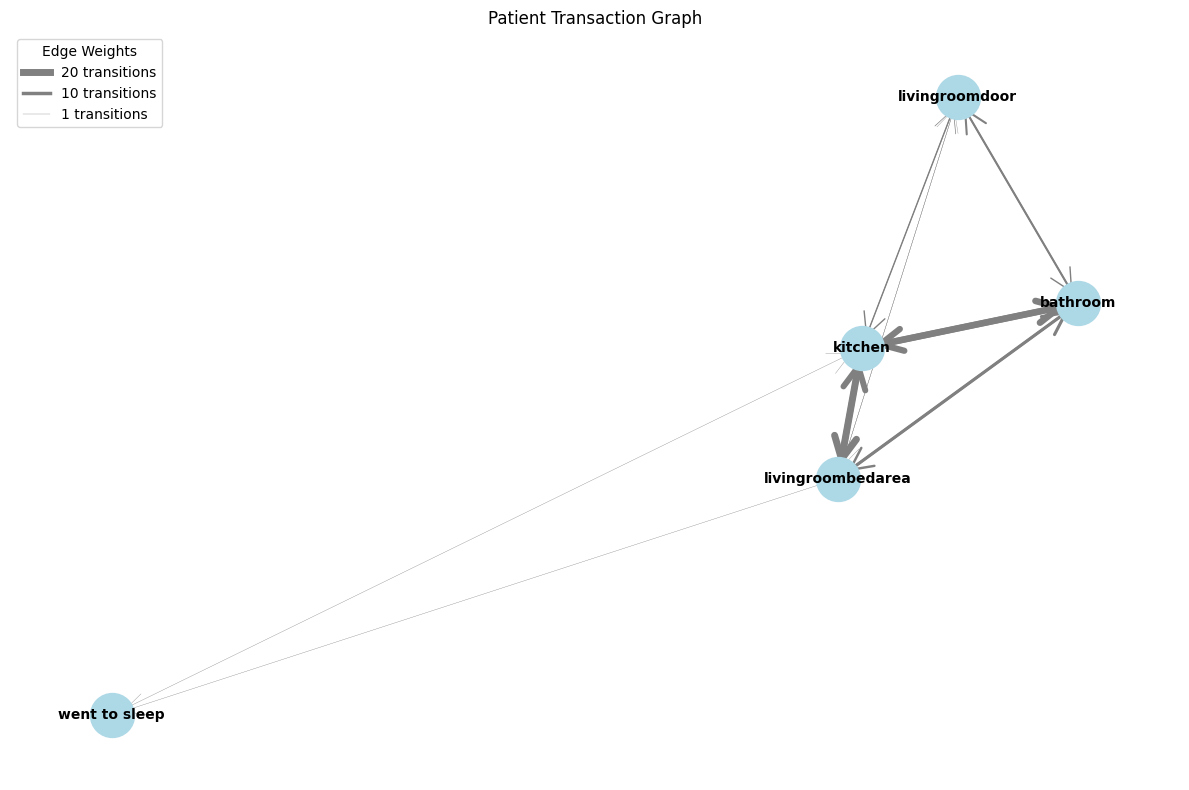

In [4]:
plot_bidirectional_transaction_graph(old_model)

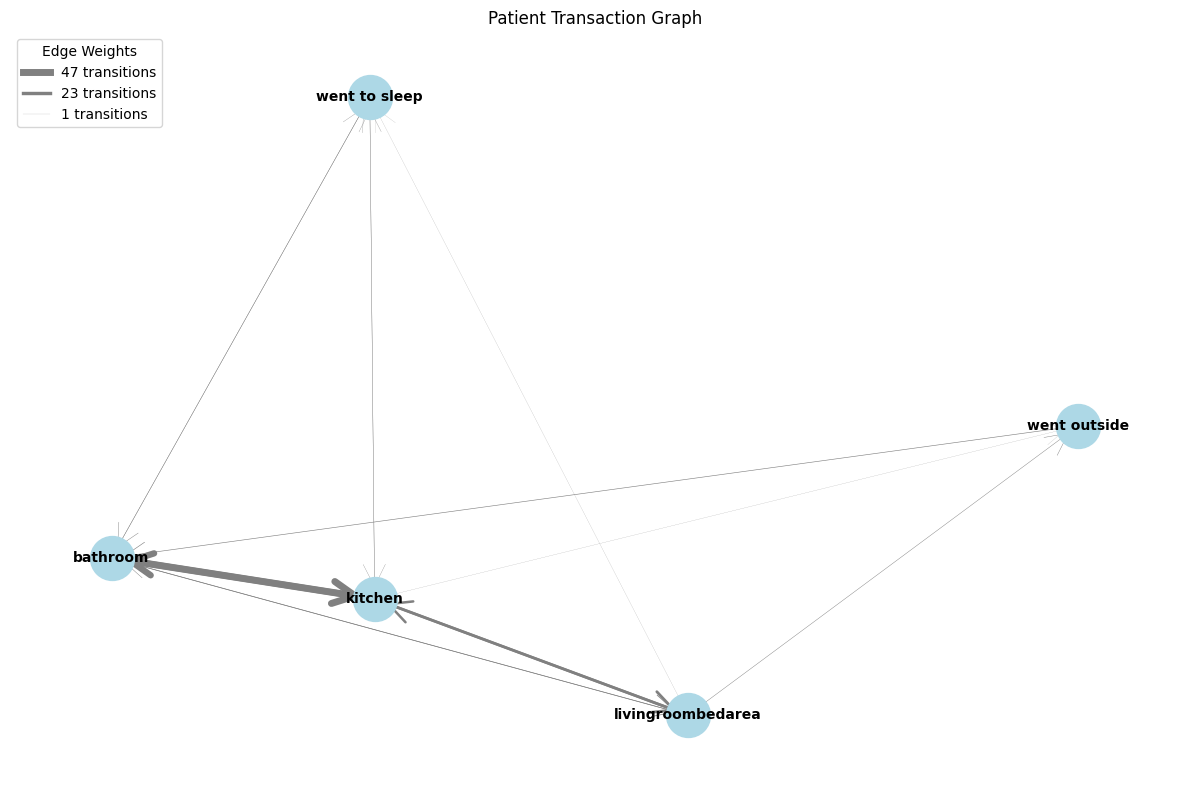

In [5]:
plot_bidirectional_transaction_graph(new_model)

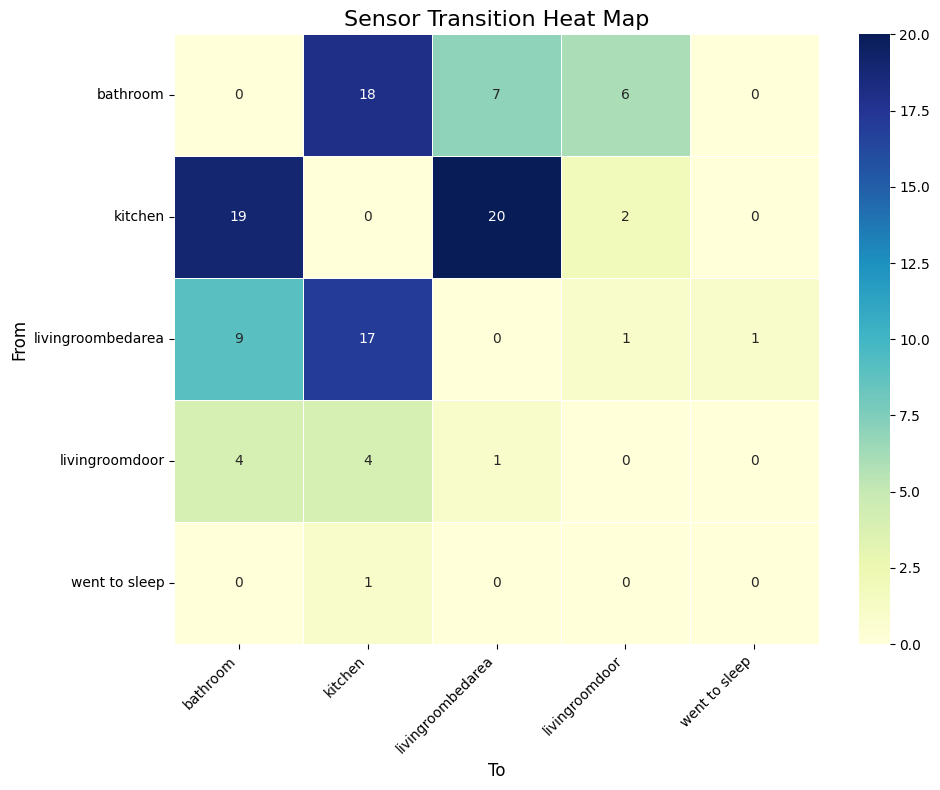

In [6]:
visualize_transitions_heatmap(old_model)

#### Counting the sleep and went outside periods

In [7]:
summary_of_sleep_time_and_time_outside(old_model)

2025-01-03 14:29:50 [WARNING] motion_analysis - No valid sleep periods found.


,date,day_of_week,sleep_time,time_outside
0,2024-12-21,Saturday,5h 53m,0


In [8]:
summary_of_sleep_time_and_time_outside(new_model)

,date,day_of_week,sleep_time,time_outside
0,2025-01-01,Wednesday,0,1h 22m
1,2025-01-02,Thursday,8h 30m,4h 14m
2,2025-01-03,Friday,5h 12m,0


#### Detect daliy trips to places

In [3]:
count_daily_visits(new_model, transition_state='bathroom')

,trip_date,bathroom_trip_count
0,2025-01-01,1
1,2025-01-02,29
2,2025-01-03,23


In [13]:
count_daily_visits(new_model, transition_state='kitchen')

,trip_date,kitchen_trip_count
0,2024-11-22,12
1,2024-11-23,41
2,2024-11-24,76
3,2024-11-25,23
4,2024-11-26,55
5,2024-11-27,13
6,2024-11-28,9


In [5]:
count_daily_visits(new_model, transition_state='livingroombedarea')

,trip_date,livingroombedarea_trip_count
0,2025-01-01,1
1,2025-01-02,22
2,2025-01-03,1


In [6]:
count_daily_visits(old_model, transition_state='livingroomdoor')

,trip_date,livingroomdoor_trip_count
0,2024-12-20,9


### Wake up times

In [7]:
detect_wake_up_times(new_model)

,wake_up_time
4,2025-01-02 01:21:35.170
6,2025-01-02 08:18:47.541
102,2025-01-03 02:40:19.488
104,2025-01-03 04:43:04.492
106,2025-01-03 05:45:50.989


In [15]:
detect_went_to_sleep_times(old_model)

,went_to_sleep
110,2024-12-01 22:12:10.000
112,2024-12-01 23:08:19.118
114,2024-12-02 04:23:16.000
123,2024-12-02 23:28:33.267
179,2024-12-04 00:14:02.441
183,2024-12-04 06:14:26.732
227,2024-12-05 01:14:20.083
229,2024-12-05 05:31:38.079
288,2024-12-06 01:01:32.820


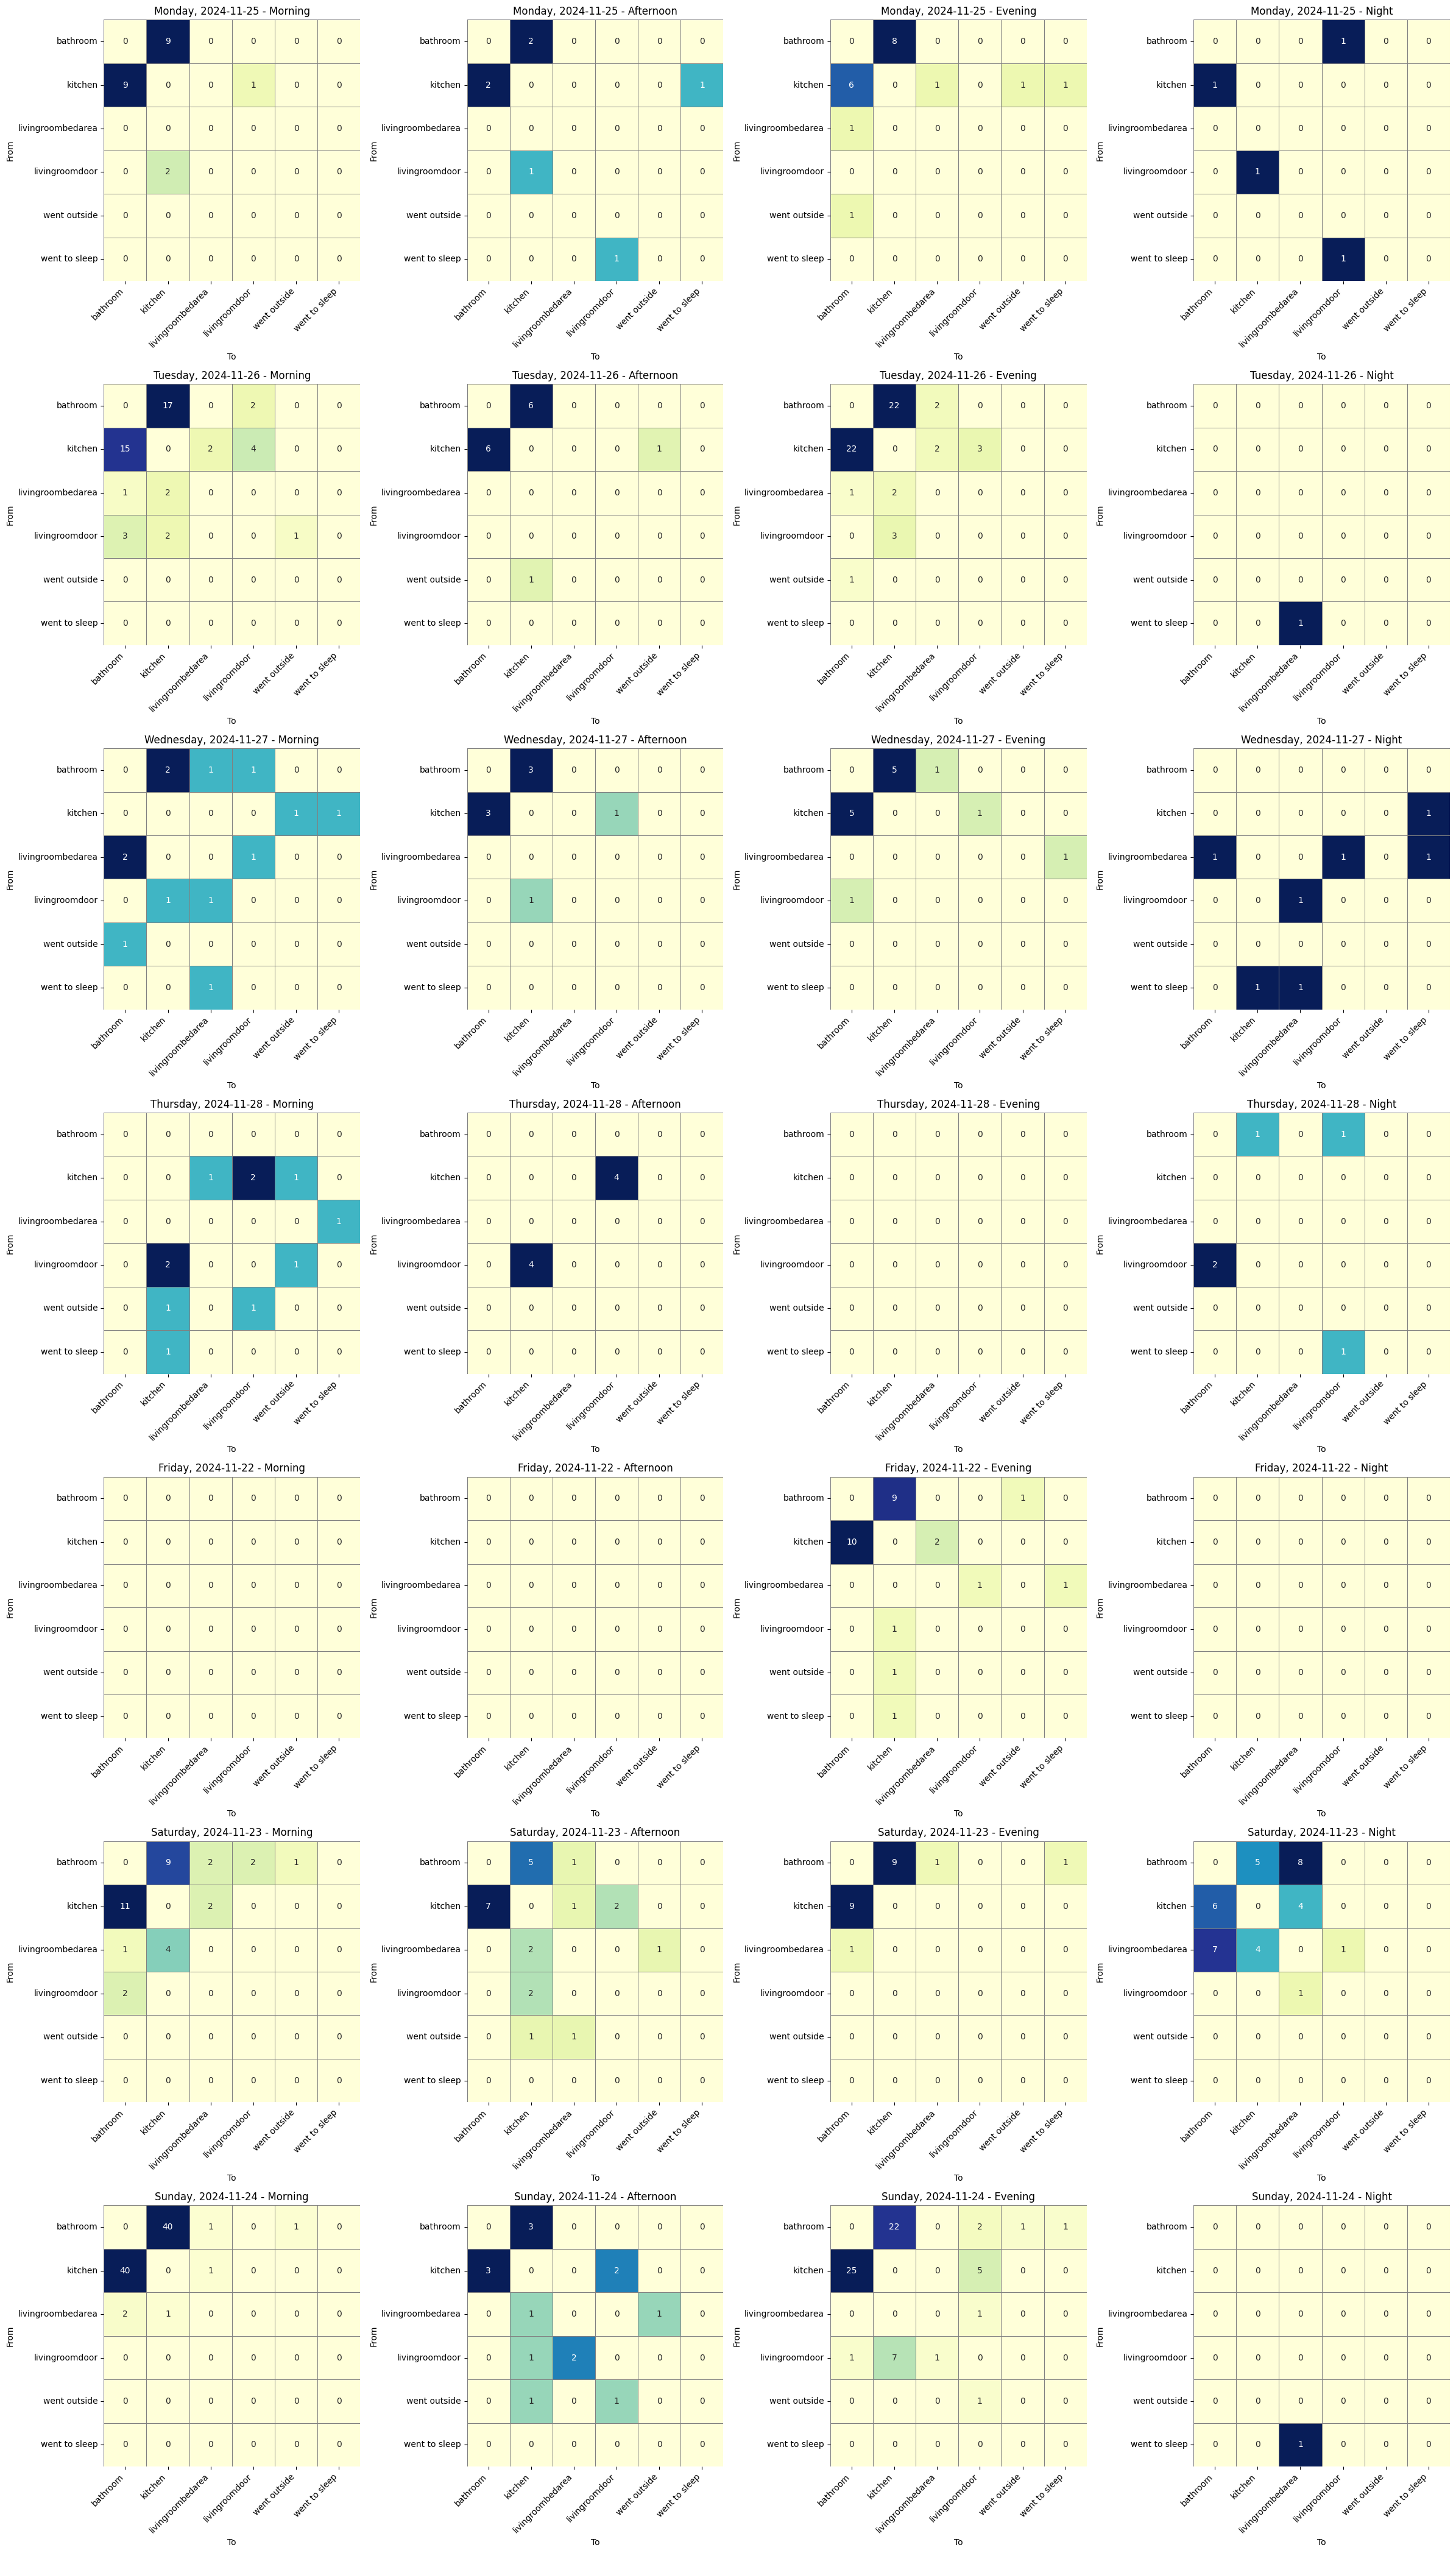

In [14]:
create_separate_heat_maps(new_model)

In [2]:
analyse_motion_patterns()

2025-01-03 14:45:03 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 14:45:04 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-03 14:45:04 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 14:45:04 [INFO] motion_analysis -         date day_of_week sleep_time time_outside
0 2024-11-29      Friday          0       6h 16m
1 2024-11-30    Saturday          0  